In [53]:
import numpy as np
import os,math,random
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic, binned_statistic_2d
from astropy.table import Table, vstack
from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy import units as u
from astropy.constants import k_B, m_p, G, M_sun
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from gdpyc import GasMap, DustMap
import time
import pandas as pd
from scipy.interpolate import interp2d, interp1d
from scipy import interpolate

In [2]:
cosmo = FlatLambdaCDM(Om0=0.315,H0=100)

In [38]:
def isLRG_colors(gflux=None, rflux=None, zflux=None, w1flux=None,
                 zfiberflux=None, ggood=None,
                 w2flux=None, primary=None, south=True):
    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    lrg = primary.copy()
    # ADM to maintain backwards-compatibility with mocks.
    if zfiberflux is None:
        log.warning('Setting zfiberflux to zflux!!!')
        zfiberflux = zflux.copy()
    gmag = 22.5 - 2.5 * np.log10(gflux.clip(1e-7))
    # ADM safe as these fluxes are set to > 0 in notinLRG_mask.
    rmag = 22.5 - 2.5 * np.log10(rflux.clip(1e-7))
    zmag = 22.5 - 2.5 * np.log10(zflux.clip(1e-7))
    w1mag = 22.5 - 2.5 * np.log10(w1flux.clip(1e-7))
    zfibermag = 22.5 - 2.5 * np.log10(zfiberflux.clip(1e-7))
    # Full SV3 selection
    if south:
        lrg &= zmag - w1mag > 0.8 * (rmag - zmag) - 0.6  # non-stellar cut
        lrg &= zfibermag < 21.6                   # faint limit
        lrg &= (gmag - w1mag > 2.9) | (rmag - w1mag > 1.8)  # low-z cuts
        lrg &= (
            ((rmag - w1mag > (w1mag - 17.14) * 1.8)
             & (rmag - w1mag > (w1mag - 16.33) * 1.))
            | (rmag - w1mag > 3.3)
        )  # double sliding cuts and high-z extension
    else:
        lrg &= zmag - w1mag > 0.8 * (rmag - zmag) - 0.6  # non-stellar cut
        lrg &= zfibermag < 21.61                   # faint limit
        lrg &= (gmag - w1mag > 2.97) | (rmag - w1mag > 1.8)  # low-z cuts
        lrg &= (
            ((rmag - w1mag > (w1mag - 17.13) * 1.83)
             & (rmag - w1mag > (w1mag - 16.31) * 1.))
            | (rmag - w1mag > 3.4)
        )  # double sliding cuts and high-z extension
    return lrg

def isELG_colors(gflux=None, rflux=None, zflux=None, w1flux=None,
                 w2flux=None, gfiberflux=None, south=True, primary=None):
    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    elg = primary.copy()
    # ADM work in magnitudes instead of fluxes. NOTE THIS IS ONLY OK AS
    # ADM the snr masking in ALL OF g, r AND z ENSURES positive fluxes.
    g = 22.5 - 2.5*np.log10(gflux.clip(1e-16))
    r = 22.5 - 2.5*np.log10(rflux.clip(1e-16))
    z = 22.5 - 2.5*np.log10(zflux.clip(1e-16))
    gfib = 22.5 - 2.5*np.log10(gfiberflux.clip(1e-16))
    # ADM cuts shared by the northern and southern selections.
    elg &= g > 20                       # bright cut.
    elg &= r - z > 0.15                  # blue cut.
#    elg &= r - z < 1.6                  # red cut.
    # ADM cuts that are unique to the north or south. Identical for sv3
    # ADM but keep the north/south formalism in case we use it later.
    if south:
        elg &= gfib < 24.1  # faint cut.
        elg &= g - r < 0.5*(r - z) + 0.1  # remove stars, low-z galaxies.
    else:
        elg &= gfib < 24.1  # faint cut.
        elg &= g - r < 0.5*(r - z) + 0.1  # remove stars, low-z galaxies.
    # ADM separate a low-priority and a regular sample.
    elgvlo = elg.copy()
    # ADM low-priority OII flux cut.
    elgvlo &= g - r < -1.2*(r - z) + 1.6
    elgvlo &= g - r >= -1.2*(r - z) + 1.3
    # ADM high-priority OII flux cut.
    elg &= g - r < -1.2*(r - z) + 1.3
    return elgvlo, elg

In [20]:
Cens = Table.read('../data/DESI/CensACT.fits')
Cens['R180'] = (((10**Cens['logMh']*M_sun)/(4*np.pi/3*180*cosmo.Om(0)*3*(cosmo.H0**2)/(8*np.pi*G)))**(1./3)).to('kpc')/(1+Cens['z'])
Cens['R180_ang'] = Cens['R180']/cosmo.angular_diameter_distance(Cens['z']).to('kpc')

bcg_pos = SkyCoord(Cens['ra']*u.deg, Cens['dec']*u.deg)
xry_pos = SkyCoord(Cens['RA_X']*u.deg, Cens['DEC_X']*u.deg)
luw_pos = SkyCoord(Cens['ragroup']*u.deg, Cens['decgroup']*u.deg)

In [51]:
Cens['nH'] = GasMap.nh(xry_pos, nhmap='DL').to('1/cm2').value

In [34]:
Sats = Table.read('../data/DESI/SatsLite.fits')

In [42]:
# BPT
sn_thre_ = 2
Cens['is_BPT'] = np.zeros(len(Cens))-99
sel_thre_s = (Cens['SN_NII']>=sn_thre_)&(Cens['SN_HA']>=sn_thre_)&(Cens['SN_OIII']>=sn_thre_)&(Cens['SN_HB']>=sn_thre_)
sel_thre_w = (Cens['SN_NII']>=sn_thre_)&(Cens['SN_HA']>=sn_thre_)&((Cens['SN_OIII']<sn_thre_)|(Cens['SN_HB']<sn_thre_))
Cens['is_BPT'][(sel_thre_s|sel_thre_w)] = 1
sel_CN_a_ = (Cens['BPTOIII']>0.61/(Cens['BPTNII']-0.47)+1.19)|(Cens['BPTNII']>=0.47)
sel_CN_w_ = (Cens['EWHA']>np.log10(3))&(Cens['BPTNII']>-0.1)
Cens['is_BPT'][(sel_thre_s&sel_CN_a_)|(sel_thre_w&sel_CN_w_)] = 2
sel_CN_as = (Cens['BPTOIII']<0.61/(Cens['BPTNII']-0.05)+1.3)&(Cens['BPTNII']<0.05)
sel_CN_ws = (Cens['SN_NII']>sn_thre_)&(Cens['SN_HA']>sn_thre_)&((Cens['SN_OIII']<=sn_thre_)|(Cens['SN_HB']<=sn_thre_))&((Cens['BPTNII']<-0.32)|(Cens['EWHA']<np.log10(3)))
Cens['is_BPT'][(sel_thre_s&sel_CN_as)|(sel_thre_w&sel_CN_ws)] = 0

Sats['is_BPT'] = np.zeros(len(Sats))-99
sel_thre_s = (Sats['SN_NII']>=sn_thre_)&(Sats['SN_HA']>=sn_thre_)&(Sats['SN_OIII']>=sn_thre_)&(Sats['SN_HB']>=sn_thre_)
sel_thre_w = (Sats['SN_NII']>=sn_thre_)&(Sats['SN_HA']>=sn_thre_)&((Sats['SN_OIII']<sn_thre_)|(Sats['SN_HB']<sn_thre_))
Sats['is_BPT'][(sel_thre_s|sel_thre_w)] = 1
sel_CN_a_ = (Sats['BPTOIII']>0.61/(Sats['BPTNII']-0.47)+1.19)|(Sats['BPTNII']>=0.47)
sel_CN_w_ = (Sats['EWHA']>np.log10(3))&(Sats['BPTNII']>-0.1)
Sats['is_BPT'][(sel_thre_s&sel_CN_a_)|(sel_thre_w&sel_CN_w_)] = 2
sel_CN_as = (Sats['BPTOIII']<0.61/(Sats['BPTNII']-0.05)+1.3)&(Sats['BPTNII']<0.05)
sel_CN_ws = (Sats['SN_NII']>sn_thre_)&(Sats['SN_HA']>sn_thre_)&((Sats['SN_OIII']<=sn_thre_)|(Sats['SN_HB']<=sn_thre_))&((Sats['BPTNII']<-0.32)|(Sats['EWHA']<np.log10(3)))
Sats['is_BPT'][(sel_thre_s&sel_CN_as)|(sel_thre_w&sel_CN_ws)] = 0

In [84]:
Cens['seq'] = np.zeros((len(Cens),2)).astype('int')
xx_ = (Cens['ra']!=Cens['RA_X'])
Cens['seq'][:,0][xx_] = 1
Cens['seq'][:,1][~(xx_)] = 1

In [45]:
gflux=Sats['FLUX_G']/Sats['MW_TRANSMISSION_G']
rflux=Sats['FLUX_R']/Sats['MW_TRANSMISSION_R']
zflux=Sats['FLUX_Z']/Sats['MW_TRANSMISSION_Z']
w1flux=Sats['FLUX_W1']/Sats['MW_TRANSMISSION_W1']
w2flux=Sats['FLUX_W2']/Sats['MW_TRANSMISSION_W2']
gfiberflux=Sats['FIBERFLUX_G']/Sats['MW_TRANSMISSION_G']
rfiberflux=Sats['FIBERFLUX_R']/Sats['MW_TRANSMISSION_R']
zfiberflux=Sats['FIBERFLUX_Z']/Sats['MW_TRANSMISSION_Z']
rfibertotflux=Sats['FIBERTOTFLUX_R']/Sats['MW_TRANSMISSION_R']

/var/folders/8k/p6qnzbn934jd2z75vwrs1j2h0000gn/T/ipykernel_5300/2621183821.py:1: RuntimeWarning: invalid value encountered in divide
  gflux=Sats['FLUX_G']/Sats['MW_TRANSMISSION_G']
/var/folders/8k/p6qnzbn934jd2z75vwrs1j2h0000gn/T/ipykernel_5300/2621183821.py:2: RuntimeWarning: invalid value encountered in divide
  rflux=Sats['FLUX_R']/Sats['MW_TRANSMISSION_R']
/var/folders/8k/p6qnzbn934jd2z75vwrs1j2h0000gn/T/ipykernel_5300/2621183821.py:3: RuntimeWarning: invalid value encountered in divide
  zflux=Sats['FLUX_Z']/Sats['MW_TRANSMISSION_Z']
/var/folders/8k/p6qnzbn934jd2z75vwrs1j2h0000gn/T/ipykernel_5300/2621183821.py:4: RuntimeWarning: invalid value encountered in divide
  w1flux=Sats['FLUX_W1']/Sats['MW_TRANSMISSION_W1']
/var/folders/8k/p6qnzbn934jd2z75vwrs1j2h0000gn/T/ipykernel_5300/2621183821.py:5: RuntimeWarning: invalid value encountered in divide
  w2flux=Sats['FLUX_W2']/Sats['MW_TRANSMISSION_W2']
/var/folders/8k/p6qnzbn934jd2z75vwrs1j2h0000gn/T/ipykernel_5300/2621183821.py:6: Run

In [46]:
elglo_iron, elg_iron = isELG_colors(gflux=gflux, rflux=rflux, zflux=zflux, w1flux=w1flux, w2flux=w2flux, gfiberflux=gfiberflux, south=True, primary=None)
lrg_iron = isLRG_colors(gflux=gflux, rflux=rflux, zflux=zflux, w1flux=w1flux, zfiberflux=zfiberflux, ggood=None, w2flux=w2flux, primary=None, south=True)

Sats['ELG'] = (elglo_iron|elg_iron)
Sats['LRG'] = lrg_iron
radio_sat = (Sats['ASKAP_idx']>0)
qso_sat = (Sats['is_QSO']==1)
bpt_sat = (Sats['is_BPT']>=1)
Sats = Sats[(Sats['ELG']==1)|(Sats['LRG']==1)|radio_sat|qso_sat|bpt_sat]

In [21]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    mask = dist_from_center <= radius
    return mask

## $2 \times 2$ bins in $M_h$ and Redshift Spaces

In [22]:
step = 0.5
mbins = np.arange(14,15.1,step)
layers = 2

r180_min = np.zeros((2,len(mbins)-1))
r180_med = np.zeros((2,len(mbins)-1))
r180_max = np.zeros((2,len(mbins)-1))
r180_min_ang = np.zeros((2,len(mbins)-1))
r180_med_ang = np.zeros((2,len(mbins)-1))
r180_max_ang = np.zeros((2,len(mbins)-1))

for zz in range(2):
    for mm in range(len(mbins)-1):
        r180_min[zz,mm] = (((10**mbins[mm]*M_sun)/(4*np.pi/3*180*cosmo.Om(0)*3*cosmo.H0**2/(8*np.pi*G)))**(1./3)).to('kpc').value/(1+0.5*(zz+1))
        r180_med[zz,mm] = (((10**((mbins[mm]+mbins[mm+1])/2)*M_sun)/(4*np.pi/3*180*cosmo.Om(0)*3*cosmo.H0**2/(8*np.pi*G)))**(1./3)).to('kpc').value/(1+0.5*(zz+0.5))
        r180_max[zz,mm] = (((10**(mbins[mm+1])*M_sun)/(4*np.pi/3*180*cosmo.Om(0)*3*cosmo.H0**2/(8*np.pi*G)))**(1./3)).to('kpc').value/(1+0.5*zz)
        r180_min_ang[zz,mm] = r180_min[zz,mm]/cosmo.angular_diameter_distance(0.25+0.5*zz).to('kpc').value
        r180_med_ang[zz,mm] = r180_med[zz,mm]/cosmo.angular_diameter_distance(0.25+0.5*zz).to('kpc').value
        r180_max_ang[zz,mm] = r180_max[zz,mm]/cosmo.angular_diameter_distance(0.25+0.5*zz).to('kpc').value

## eROSITA Tiles Info

In [23]:
tiles = fits.open('../data/eROSITA/SKYMAPS_052022_MPE.fits')
tlt_select = Table(tiles[1].data)
# l_ = elt.transform_to('galactic').l.to('deg').value
elt_sel = SkyCoord(tlt_select['RA_CEN']*u.deg,tlt_select['DE_CEN']*u.deg)

Emin, Emax = 0.5, 2
zoom, zoom2 = 0.5, 4
# idx_srv, d2d_srv, d3d_srv = xry_pos.match_to_catalog_sky(elt_sel)
# srv_n = [i for i in set(tlt_select['SRVMAP'][idx_srv])]

In [24]:
Cens['svmapx'] = np.zeros(len(Cens)).astype('i4')
for kk in range(-69,43,3):
    sel_ = (Cens['DEC_X']>kk-1.5)&(Cens['DEC_X']<=kk+1.5)
    els_ = (tlt_select['DE_CEN']>kk-1.5)&(tlt_select['DE_CEN']<=kk+1.5)
    idx_srv, d2d_srv, d3d_srv = xry_pos[sel_].match_to_catalog_sky(elt_sel[els_])
    Cens['svmapx'][sel_] = tlt_select['SRVMAP'][els_][idx_srv]

In [26]:
Cens['svmapb'] = np.zeros(len(Cens)).astype('i4')
for kk in range(-69,43,3):
    sel_ = (Cens['dec']>kk-1.5)&(Cens['dec']<=kk+1.5)
    els_ = (tlt_select['DE_CEN']>kk-1.5)&(tlt_select['DE_CEN']<=kk+1.5)
    idx_srv, d2d_srv, d3d_srv = bcg_pos[sel_].match_to_catalog_sky(elt_sel[els_])
    Cens['svmapb'][sel_] = tlt_select['SRVMAP'][els_][idx_srv]

In [27]:
Cens['svmapw'] = np.zeros(len(Cens)).astype('i4')
for kk in range(-69,43,3):
    sel_ = (Cens['decgroup']>kk-1.5)&(Cens['decgroup']<=kk+1.5)
    els_ = (tlt_select['DE_CEN']>kk-1.5)&(tlt_select['DE_CEN']<=kk+1.5)
    idx_srv, d2d_srv, d3d_srv = bcg_pos[sel_].match_to_catalog_sky(elt_sel[els_])
    Cens['svmapw'][sel_] = tlt_select['SRVMAP'][els_][idx_srv]

## CTP Catalog

In [28]:
mains = Table.read('../data/eROSITA/catalogs/eRASS1_ctp.fits')
mains.sort('GR')
mainst = SkyCoord(mains['RA'].data*u.deg, mains['DEC'].data*u.deg)

In [37]:
mains['Rsrc'] = (10.754*np.log10(mains['ML_CTS_1'])**2 - 8.989*np.log10(mains['ML_CTS_1']) + 24.49)*1.4
mains['Rsrc'][mains['EXT']>0] = (15.948*np.log10(mains['ML_CTS_1'][mains['EXT']>0])**2 + 0.046*np.log10(mains['ML_CTS_1'][mains['EXT']>0]) + 34.124)*1.2

In [10]:
def tlnm_name(tlnm_):
    if len(tlnm_) == 5:
        tlnm_ = '0'+tlnm_
    elif len(tlnm_) == 4:
        tlnm_ = '00'+tlnm_
    elif len(tlnm_) == 3:
        tlnm_ = '000'+tlnm_
    return tlnm_

def rescale_(mskk, ima_size):
    f_mc = interpolate.interp2d(np.arange(mskk.shape[1]), np.arange(mskk.shape[0]), mskk, kind='linear')
    mskk_rebin = f_mc(np.linspace(0, mskk.shape[1], ima_size), np.linspace(0, mskk.shape[1], ima_size))
    mskk_rebin[mskk_rebin>=0.5] = 1
    mskk_rebin[mskk_rebin<0.5] = 0
    return mskk_rebin

def mask_conta(tabs,detmsk,xx,yy,R_ang,xxs,yys,rrs):
    msk_id = np.ones(len(tabs))
    if len(rrs) > 0:
        mask_sources = []
        for s in range(len(rrs)):
            mask_sj = create_circular_mask(detmsk.shape[0], detmsk.shape[1], 
                                           center=((xxs[s]-xx+R_ang*2), (yys[s]-yy+R_ang*2)),
                                           radius=(rrs[s]/4+30/4))
            mask_sources.append(mask_sj)
            msk_id[np.sqrt((tabs['xx']-xxs[s])**2+(tabs['yy']-yys[s])**2)<(rrs[s]/4+30/4)] = 0
        mask_contamination = 1 - np.sum(np.array(mask_sources), axis=0)
        mask_contamination[mask_contamination < 1] = 0
    else:
        mask_contamination = np.ones((detmsk.shape[0], detmsk.shape[1]))
    return msk_id, mask_contamination

In [55]:
rmf = fits.open('../data/eROSITA/ecfModels/RMF')
rmfE = Table(rmf[2].data)
rmfinfo = Table(rmf[1].data)
ee_rmf = 0.5*(rmfE['E_MIN']+rmfE['E_MAX'])
rmf_matrix = np.zeros((1024, 1024))

# Image Stacking (X-ray Center)

In [91]:
repeat_ = 51

pure_count = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]
weighted_count = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]
mask_ima = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]

pure_count_sat = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]
weighted_count_sat = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]
mask_ima_sat = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]

pure_count_sat_bq = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]
weighted_count_sat_bq = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]
mask_ima_sat_bq = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]

for hh in range(repeat_):
    for ii in range(layers):
        for jj in range(2):
            for kk in range(len(mbins)-1):
                ima_size = int(r180_min_ang[jj,kk]*180/np.pi*60*15/zoom)*4
                pure_count[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))
                weighted_count[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))
                mask_ima[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))
                pure_count_sat[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))
                weighted_count_sat[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))
                mask_ima_sat[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))
                pure_count_sat_bq[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))
                weighted_count_sat_bq[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))
                mask_ima_sat_bq[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))

In [92]:
srv_n = [i for i in set(Cens['svmapx'])]

for i in range(0,len(srv_n)):
    tlnm_ = tlnm_name(str(srv_n[i]))
    if os.path.exists('../data/eROSITA/exp_all/'+tlnm_+'_all.fits') == True:
        arf = fits.open('../data/eROSITA/ecfModels/arffiles/arf_020_ARF_00001'+tlnm_+'.fits')
        arfE = Table(arf[1].data)
        arfE['Area'] = arfE['SPECRESP']/arfE['CORRCOMB']
        ee_arf = 0.5*(arfE['ENERG_LO']+arfE['ENERG_HI'])
    else:
        print('!!!',tlnm_)
        continue
    # Counts + ExpMaps:
    fname = '../data/eROSITA/exp_all/'+tlnm_+'_all.fits'
    expnm = '../data/eROSITA/exp_all/'+tlnm_+'_all_exp.fits'
    im_ = fits.open(fname)[0].data
    et_ = fits.open(expnm)[0].data
    tab_ = Table(fits.open(fname)[1].data)
    det_ = (et_>0)
    w = WCS(fits.open(fname)[0].header)
    tltt = SkyCoord(tlt_select['RA_CEN'][tlt_select['SRVMAP']==int(tlnm_)]*u.deg, 
                    tlt_select['DE_CEN'][tlt_select['SRVMAP']==int(tlnm_)]*u.deg)
    gr_srv_id = np.where(Cens['svmapx'] == int(tlnm_))[0]
    sep_tlt = tltt.separation(mainst)
    max_ang = np.max(Cens['R180_ang'][gr_srv_id])/np.pi*180   # in deg
    ### !!!
    main_this_t = mainst[sep_tlt.to('deg').value<(2*max_ang+3.6)]
    main_this = mains[sep_tlt.to('deg').value<(2*max_ang+3.6)]
    # Image Coordinate for Each Photon
    evx, evy = w.all_world2pix(tab_['RA'], tab_['DEC'], 0)
    tab_['xx'] = evx
    tab_['yy'] = evy
    tab_['Eob'] = tab_['PI']/1000
    # Image Coordinate for Each Blind-detected Source
    emix, emiy = w.all_world2pix(main_this['RA'], main_this['DEC'], 0)
    for gi in range(0, len(gr_srv_id)):
        richness, redshift, mhalo = Cens['richness'][gr_srv_id[gi]], Cens['z'][gr_srv_id[gi]], Cens['logMh'][gr_srv_id[gi]]
        mi = int((Cens['logMh'][gr_srv_id[gi]]-14)/0.5)
        zi = int(redshift/0.50)
        if redshift < 0.005:
            continue
        if mi < 0:
            mi = 0
        elif mi > 1:
            mi = 1
        else:
            pass
        ima_size = int(r180_min_ang[zi][mi]*180/np.pi*60*15/zoom)*4
        # Basic Info
        grpid = Cens['grpid'][gr_srv_id[gi]]
        if richness > 1:
            Sat_sel = Sats[(Sats['grpid']==grpid)] #Sat Sel
        else:
            Sat_sel = Sats[1:0]
        nH = np.round(np.log10(Cens['nH'][gr_srv_id[gi]].data),1)
        spec0 = Table.read('../data/eROSITA/nHcorr/abp'+str(int(10*nH))+'.fits')
        if nH > 21.0:
            continue
        lum_dist = cosmo.luminosity_distance(redshift).to('cm').value
        # theta_180 in pix
        maxR = int(Cens['R180_ang'][gr_srv_id[gi]]/np.pi*180*60*15)    # in pix^2
        ratio1 = (Cens['R180'][gr_srv_id[gi]]/(ima_size/4))**2         # ? kpc^2 in one pix^2
        # Image Coordinate for BGG
        xx, yy = w.all_world2pix(Cens['RA_X'][gr_srv_id[gi]], Cens['DEC_X'][gr_srv_id[gi]], 0) # !
        xx_c, yy_c = w.all_world2pix(Cens['ra'][gr_srv_id[gi]], Cens['dec'][gr_srv_id[gi]], 0)
        xx_s, yy_s = w.all_world2pix(Sat_sel['ra'], Sat_sel['dec'], 0)
        xx, yy = np.round(xx, 0).astype('int'), np.round(yy, 0).astype('int')
        xx_c, yy_c = np.round(xx_c, 0).astype('int'), np.round(yy_c, 0).astype('int')
        xx_s, yy_s = np.round(xx_s, 0).astype('int'), np.round(yy_s, 0).astype('int')
        if (xx-maxR*2>=0)&(xx+maxR*2+1<3240)&(yy-maxR*2>=0)&(yy+maxR*2+1<3240):
            et_cut1 = et_[yy-maxR*2:yy+maxR*2, xx-maxR*2:xx+maxR*2]
        elif (xx-maxR*2>=3240)|(xx+maxR*2<0)|(yy-maxR*2>=3240)|(yy+maxR*2<0):
            print('!!!!!!')
            continue
        else:
            et_cut1 = np.zeros((maxR*4, maxR*4))
            eii_ = abs(yy-maxR*2)-np.max([yy-maxR*2,0])
            eji_ = abs(xx-maxR*2)-np.max([xx-maxR*2,0])
            eif_ = np.min([yy+maxR*2,3240])-np.max([yy-maxR*2,0])
            ejf_ = np.min([xx+maxR*2,3240])-np.max([xx-maxR*2,0])
            et_cut1[eii_:eii_+eif_, eji_:eji_+ejf_] = et_[np.max([yy-maxR*2,0]):np.min([yy+maxR*2,3240]), np.max([xx-maxR*2,0]):np.min([xx+maxR*2,3240])]
        f_et1 = interpolate.interp2d(np.arange(et_cut1.shape[1]), np.arange(et_cut1.shape[0]), et_cut1, kind='linear')
        et_cut_rebin1 = f_et1(np.linspace(0, et_cut1.shape[1], ima_size), 
                              np.linspace(0, et_cut1.shape[1], ima_size))
        detmsk1 = (et_cut1 > 0)
        detmsk_rebin1 = (et_cut_rebin1 > 0)
        tab_['Erf'] = tab_['PI']/1000*(1+redshift)
        tab_sel = tab_[(abs(xx-evx)<maxR*2)&(abs(yy-evy)<maxR*2)&(tab_['Erf']>=Emin)&(tab_['Erf']<=Emax)&(abs(tab_['xx'].astype('int')-1619.5)<1620)&(abs(tab_['yy'].astype('int')-1619.5)<1620)]
        tab_sel['texp0'] = et_[tab_sel['xx'].astype('int'), tab_sel['yy'].astype('int')]
        tab_sel['ebin'] = np.argmin((tab_sel['Eob'].data.reshape(-1,1)-rmfinfo['ENERG_LO'].data)*(tab_sel['Eob'].data.reshape(-1,1)-rmfinfo['ENERG_HI'].data), axis=1)
        tab_sel['ebinss'] = np.argmin((tab_sel['Eob'].data.reshape(-1,1)-spec0['elo'].data)*(tab_sel['Eob'].data.reshape(-1,1)-spec0['ehi'].data), axis=1)
        tab_sel['wei'] = tab_sel['Erf']/(arfE['Area'][tab_sel['ebin'].data])*4*np.pi*(lum_dist**2)/(tab_sel['texp0'])*1.6022e-9/spec0['flux'].data[tab_sel['ebinss'].data]
        tab_sel['msk'] = np.ones(len(tab_sel))
        # Mask the Contaminants
        sep_main = xry_pos[gr_srv_id[gi]].separation(main_this_t)
        near_mask = np.where(((sep_main.to('arcsec').value-main_this['EXT']-30)/(maxR*4*2)<1.01)
                         &((main_this['GR']!=grpid)|(main_this['Sat']!=0)))[0] 
                            # not belong this group or satellites
        msk_id, mask_contamination1 = mask_conta(tab_sel,detmsk1,xx,yy,maxR,emix[near_mask],emiy[near_mask],(main_this['Rsrc'][near_mask]-30))
        # Mark the Satellites
        sat_sel1 = ((Sat_sel['ELG']==True)|(Sat_sel['LRG']==True)|(Sat_sel['ASKAP_idx']>0))
        msk_id1, mask_contamination01 = mask_conta(tab_sel,detmsk1,xx,yy,maxR,xx_s[sat_sel1],yy_s[sat_sel1],np.zeros(len(xx_s[sat_sel1]))) ######
        sat_sel3 = ((Sat_sel['ELG']==False)&(Sat_sel['LRG']==False)&(Sat_sel['ASKAP_idx']<=0)&((Sat_sel['is_QSO']==True)|(Sat_sel['is_BPT']>=1)))
        msk_id3, mask_contamination03 = mask_conta(tab_sel,detmsk1,xx,yy,maxR,xx_s[sat_sel3],yy_s[sat_sel3],np.zeros(len(xx_s[sat_sel3]))) ######
        mask_conta_rebin1 = rescale_(mask_contamination1, ima_size)
        mask_conta_rebin01 = rescale_(mask_contamination01, ima_size)
        mask_conta_rebin03 = rescale_(mask_contamination03, ima_size)
        if np.min(detmsk_rebin1) == True:
            masks_1 = mask_conta_rebin1*ratio1
            masks_01 = mask_conta_rebin1*mask_conta_rebin01*ratio1
            masks_03 = mask_conta_rebin1*mask_conta_rebin01*mask_conta_rebin03*ratio1
        else:
            masks_1 = mask_conta_rebin1*detmsk_rebin1*ratio1
            masks_01 = mask_conta_rebin1*mask_conta_rebin01*detmsk_rebin1*ratio1
            masks_03 = mask_conta_rebin1*mask_conta_rebin01*mask_conta_rebin03*detmsk_rebin1*ratio1
        if len(tab_sel) > 0:
            im2d_1, x2d, y2d, im2_ = binned_statistic_2d(tab_sel['xx'], tab_sel['yy'], msk_id, \
                bins=[np.linspace(xx-maxR*2, xx+maxR*2, ima_size+1), np.linspace(yy-maxR*2, yy+maxR*2, ima_size+1)], \
                statistic='sum')
            im2dW1, x2d, y2d, im2_ = binned_statistic_2d(tab_sel['xx'], tab_sel['yy'], tab_sel['wei']*msk_id, \
                bins=[np.linspace(xx-maxR*2, xx+maxR*2, ima_size+1),np.linspace(yy-maxR*2, yy+maxR*2, ima_size+1)], \
                statistic='sum')
            im2d_01, x2d, y2d, im2_ = binned_statistic_2d(tab_sel['xx'], tab_sel['yy'], msk_id*msk_id1, \
                bins=[np.linspace(xx-maxR*2, xx+maxR*2, ima_size+1), np.linspace(yy-maxR*2, yy+maxR*2, ima_size+1)], \
                statistic='sum')
            im2dW01, x2d, y2d, im2_ = binned_statistic_2d(tab_sel['xx'], tab_sel['yy'], tab_sel['wei']*msk_id*msk_id1, \
                bins=[np.linspace(xx-maxR*2, xx+maxR*2, ima_size+1),np.linspace(yy-maxR*2, yy+maxR*2, ima_size+1)], \
                statistic='sum')
            im2d_03, x2d, y2d, im2_ = binned_statistic_2d(tab_sel['xx'], tab_sel['yy'], msk_id*msk_id1*msk_id3, \
                    bins=[np.linspace(xx-maxR*2, xx+maxR*2, ima_size+1), np.linspace(yy-maxR*2, yy+maxR*2, ima_size+1)], \
                    statistic='sum')
            im2dW03, x2d, y2d, im2_ = binned_statistic_2d(tab_sel['xx'], tab_sel['yy'], tab_sel['wei']*msk_id*msk_id1*msk_id3, \
                    bins=[np.linspace(xx-maxR*2, xx+maxR*2, ima_size+1),np.linspace(yy-maxR*2, yy+maxR*2, ima_size+1)], \
                    statistic='sum')
        else:
            im2d_1 = np.zeros((ima_size,ima_size))
            im2dW1 = np.zeros((ima_size,ima_size))
            im2d_01 = np.zeros((ima_size,ima_size))
            im2dW01 = np.zeros((ima_size,ima_size))
            im2d_03 = np.zeros((ima_size,ima_size))
            im2dW03 = np.zeros((ima_size,ima_size))
            
        seq_ = np.where(Cens['seq'][gr_srv_id[gi]]>0)[0]
        rdc_ = np.append(0,np.random.choice(repeat_-1,5,replace=False)+1)
        for ddd in range(len(rdc_)):
            for sss in range(len(seq_)):
                pure_count[rdc_[ddd]][seq_[sss]][zi][mi] += im2d_1.T
                weighted_count[rdc_[ddd]][seq_[sss]][zi][mi] += im2dW1.T
                mask_ima[rdc_[ddd]][seq_[sss]][zi][mi] += masks_1
                pure_count_sat[rdc_[ddd]][seq_[sss]][zi][mi] += im2d_01.T
                weighted_count_sat[rdc_[ddd]][seq_[sss]][zi][mi] += im2dW01.T
                mask_ima_sat[rdc_[ddd]][seq_[sss]][zi][mi] += masks_01
                pure_count_sat_bq[rdc_[ddd]][seq_[sss]][zi][mi] += im2d_03.T
                weighted_count_sat_bq[rdc_[ddd]][seq_[sss]][zi][mi] += im2dW03.T
                mask_ima_sat_bq[rdc_[ddd]][seq_[sss]][zi][mi] += masks_03


In [93]:
for ss in range(layers):
    for mmj in range(2):
        hud_list = [fits.PrimaryHDU()]
        hud_list1 = [fits.PrimaryHDU()]
        hud_list2 = [fits.PrimaryHDU()]
        hud_list3 = [fits.PrimaryHDU()]
        for zzj in range(2):
            for hh in range(repeat_):
                hud_list.append(fits.ImageHDU(pure_count[hh][ss][zzj][mmj]))
                hud_list.append(fits.ImageHDU(weighted_count[hh][ss][zzj][mmj]))
                hud_list.append(fits.ImageHDU(mask_ima[hh][ss][zzj][mmj]))
                hud_list1.append(fits.ImageHDU(pure_count_sat[hh][ss][zzj][mmj]))
                hud_list1.append(fits.ImageHDU(weighted_count_sat[hh][ss][zzj][mmj]))
                hud_list1.append(fits.ImageHDU(mask_ima_sat[hh][ss][zzj][mmj]))
                hud_list2.append(fits.ImageHDU(pure_count_sat_bq[hh][ss][zzj][mmj]))
                hud_list2.append(fits.ImageHDU(weighted_count_sat_bq[hh][ss][zzj][mmj]))
                hud_list2.append(fits.ImageHDU(mask_ima_sat_bq[hh][ss][zzj][mmj]))
        hdul = fits.HDUList(hud_list)
        hdul1 = fits.HDUList(hud_list1)
        hdul2 = fits.HDUList(hud_list2)
        hdul.writeto('../images/stacks_x/'+str(ss)+'/stim'+str(mmj)+'.fits', overwrite=True)
        hdul1.writeto('../images/stacks_x/'+str(ss)+'/stim'+str(mmj)+'_sat.fits', overwrite=True)
        hdul2.writeto('../images/stacks_x/'+str(ss)+'/stim'+str(mmj)+'_satqb.fits', overwrite=True)


## X-ray Profile

In [94]:
def prof(ima_size,leng_,rrs,wei_cnt,wei_cnt1,pure_cnt,msk_im,msk_im1,mask_bk,mask_br):
    flbins = np.zeros(leng_)
    snbins = np.zeros(leng_)
    jkbins = np.zeros(leng_)
    flbins1 = np.zeros((len(wei_cnt1),leng_))
    bkg_lvl = np.sum(wei_cnt*(mask_bk&(1-mask_br)))/np.sum(msk_im*(mask_bk&(1-mask_br)))
    bkg_lvl1 = np.sum(np.sum(wei_cnt1*(mask_bk&(1-mask_br)),axis=2),axis=1)/np.sum(np.sum(msk_im1*(mask_bk&(1-mask_br)),axis=2),axis=1)
    for rr in range(leng_-1):
        ring0 = create_circular_mask(ima_size,ima_size,center=(ima_size/2-1/2,ima_size/2-1/2),radius=ima_size/4*rrs[rr])
        ring1 = create_circular_mask(ima_size,ima_size,center=(ima_size/2-1/2,ima_size/2-1/2),radius=ima_size/4*rrs[rr+1])
        # print(rr, rrs[rr], rrs[rr+1], np.sum(np.sum((ring1&(1-ring0)))))
        flux_lvl = np.sum(wei_cnt*(ring1&(1-ring0)))/np.sum(msk_im*(ring1&(1-ring0)))-bkg_lvl
        flux_nn = np.sum(pure_cnt*(ring1&(1-ring0)))
        bkg_nn = np.sum(pure_cnt*(mask_bk&(1-mask_br)))*np.sum(msk_im*(ring1&(1-ring0)))/np.sum(msk_im*(mask_bk&(1-mask_br)))
        flux_lvl1 = np.sum(np.sum(wei_cnt1*(ring1&(1-ring0)),axis=2),axis=1)/np.sum(np.sum(msk_im1*(ring1&(1-ring0)),axis=2),axis=1)-bkg_lvl1
        flbins[rr] = flux_lvl
        snbins[rr] = flux_lvl/((flux_nn-bkg_nn)/np.sqrt(flux_nn))
        flbins1[:,rr] = flux_lvl1
    jkbins = np.std(flbins1,axis=0)
    return flbins,snbins,jkbins

In [128]:
def merge_ima(ima_size, imai, ly_idx, zi, bi, repe):
    ima0 = np.zeros((ima_size,ima_size))
    ima1 = np.zeros((repe,ima_size,ima_size))
    for j in range(len(ly_idx)):
        ima0 += imai[0][ly_idx[j]][zi][bi]
        for h in range(1,repe+1):
            ima1[h-1] += (imai[0][ly_idx[j]][zi][bi]-imai[h][ly_idx[j]][zi][bi])
    return ima0, ima1

In [134]:
mbins[-1] = 15.6
ly_idx = [[0],[1],[0,1]]
dn = len(ly_idx)

NN_bins = np.zeros((dn,2,2))
rrs = np.zeros((dn,2,2,31))*np.nan

flbin = np.zeros((dn,2,2,31))
snbin = np.zeros((dn,2,2,31))
jkbin = np.zeros((dn,2,2,31))
flbin_nos = np.zeros((dn,2,2,31))
snbin_nos = np.zeros((dn,2,2,31))
jkbin_nos = np.zeros((dn,2,2,31))
flbin_nosqb = np.zeros((dn,2,2,31))
snbin_nosqb = np.zeros((dn,2,2,31))
jkbin_nosqb = np.zeros((dn,2,2,31))

for bj in range(len(mbins)-1):
    for bk in range(2):
        ima_size = int(r180_min_ang[bk][bj]*180/np.pi*60*15/zoom)*4
        if int(1.5*ima_size/4) < 16:
            leng_ = 16
        elif int(1.5*ima_size/4) > 30:
            leng_ = 31
        else:
            leng_ = int(ima_size/4)
        sels_ = (Cens['logMh']>=mbins[bj])&(Cens['logMh']<mbins[bj+1])&(Cens['z']>=0.5*bk)&(Cens['z']<=0.5*(bk+1))
        for i in range(len(ly_idx)):
            rrs[i,bk,bj][:leng_] = np.linspace(0,1.5,num=leng_,endpoint=True)
            num_ = 0
            for j in range(len(ly_idx[i])):
                num_ += np.sum(sels_&(Cens['seq'].T[ly_idx[i][j]]>0))
            NN_bins[i,bk,bj] = num_
            
            mask_bk = create_circular_mask(ima_size, ima_size, center=(ima_size/2, ima_size/2), radius=ima_size/4*2)
            mask_br = create_circular_mask(ima_size, ima_size, center=(ima_size/2, ima_size/2), radius=ima_size/4*1.5)
            pure_cnt, pure_cnt1 = merge_ima(ima_size, pure_count, ly_idx[i], bk ,bj, 50)
            wei_cnt, wei_cnt1 = merge_ima(ima_size, weighted_count, ly_idx[i], bk ,bj, 50)
            msk_im, msk_im1 = merge_ima(ima_size, mask_ima, ly_idx[i], bk ,bj, 50)
            pure_cnt_sat, pure_cnt_sat1 = merge_ima(ima_size, pure_count_sat, ly_idx[i], bk ,bj, 50)
            wei_cnt_sat, wei_cnt_sat1 = merge_ima(ima_size, weighted_count_sat, ly_idx[i], bk ,bj, 50)
            msk_im_sat, msk_im_sat1 = merge_ima(ima_size, mask_ima_sat, ly_idx[i], bk ,bj, 50)
            pure_cnt_satq, pure_cnt_satq1 = merge_ima(ima_size, pure_count_sat_bq, ly_idx[i], bk ,bj, 50)
            wei_cnt_satq, wei_cnt_satq1 = merge_ima(ima_size, weighted_count_sat_bq, ly_idx[i], bk ,bj, 50)
            msk_im_satq, msk_im_satq1 = merge_ima(ima_size, mask_ima_sat_bq, ly_idx[i], bk ,bj, 50)
            
            flbin0, snbin0, jkbin0 = prof(ima_size,leng_,rrs[i,bk,bj][:leng_],wei_cnt,wei_cnt1,pure_cnt,msk_im,msk_im1,mask_bk,mask_br)
            flbin[i,bk,bj,:leng_] = flbin0
            snbin[i,bk,bj,:leng_] = snbin0
            jkbin[i,bk,bj,:leng_] = jkbin0
            flbin0, snbin0, jkbin0 = prof(ima_size,leng_,rrs[i,bk,bj][:leng_],wei_cnt_sat,wei_cnt_sat1,pure_cnt_sat,msk_im_sat,msk_im_sat1,mask_bk,mask_br)
            flbin_nos[i,bk,bj,:leng_] = flbin0
            snbin_nos[i,bk,bj,:leng_] = snbin0
            jkbin_nos[i,bk,bj,:leng_] = jkbin0
            flbin0, snbin0, jkbin0 = prof(ima_size,leng_,rrs[i,bk,bj][:leng_],wei_cnt_satq,wei_cnt_satq1,pure_cnt_satq,msk_im_satq,msk_im_satq1,mask_bk,mask_br)
            flbin_nosqb[i,bk,bj,:leng_] = flbin0
            snbin_nosqb[i,bk,bj,:leng_] = snbin0
            jkbin_nosqb[i,bk,bj,:leng_] = jkbin0

In [132]:
def err_plot(xval, yval, yerr, clre, clrf, clre2, lbl, alp, mk, ms):
    p1, le1, ba1 = ax.errorbar(x=xval, y=yval, yerr=yerr,
                       mec=clre, mfc=clrf, 
                       linestyle='',marker=mk, ms=ms, capsize=4, mew=1.2, alpha=alp, lw=1.2,label=lbl)
    le1[0].set_color(clre2)
    le1[1].set_color(clre2)
    ba1[0].set_color(clre2)
    le1[0].set_marker("_")
    le1[1].set_marker("_")

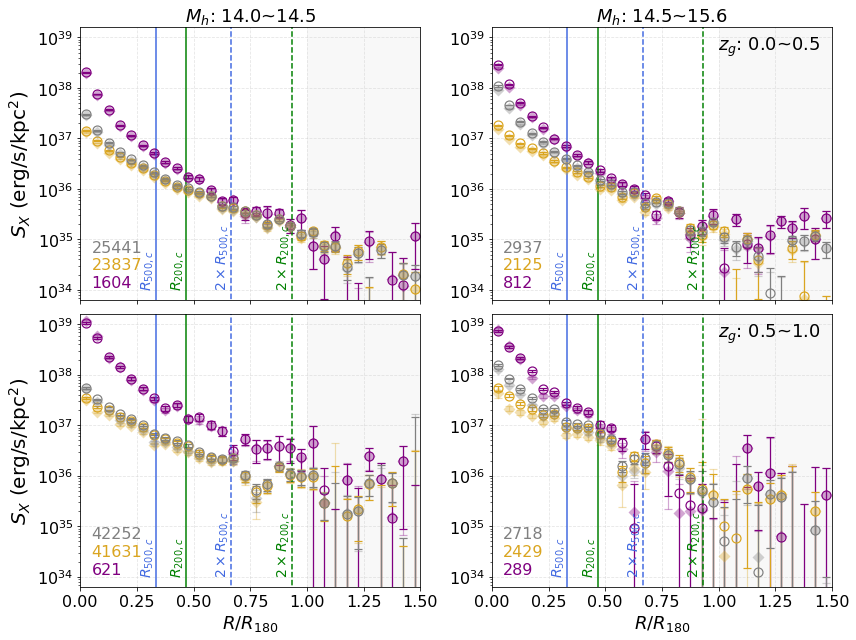

In [152]:
fig = plt.figure(figsize=(12,9))
cl_names = ['purple','goldenrod','grey']

for bk in range(2):
    for bj in range(len(mbins)-1):
        ax = fig.add_subplot(2,2,2*bk+bj+1)
        plt.grid(linestyle='dashed', color='#cccccc',zorder=2,alpha=0.5)
        ax.fill_between([1,2],[0,0],[1e50,1e50],fc='gainsboro',ec='none',alpha=0.2)
        plt.xlim(0.0, 1.5)
        plt.yscale('log')
        ymx = 39.2
        ymn = ymx-5.4
#         ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
        plt.ylim(10**ymn,10**ymx)
        
        for i in range(dn):
            num_ = NN_bins[i,bk,bj]
            if num_ < 100:
                continue
            xval = 0.5*(rrs[i,bk,bj][:-1]+rrs[i,bk,bj][1:])
            yval1 = flbin[i,bk,bj][:-1]
            yerr1 = np.sqrt(snbin[i,bk,bj][:-1]**2+jkbin[i,bk,bj][:-1]**2)
            yval = flbin_nosqb[i,bk,bj][:-1]
            yerr = np.sqrt(snbin_nosqb[i,bk,bj][:-1]**2+jkbin_nosqb[i,bk,bj][:-1]**2)

            err_plot(xval, yval, yerr, 'none', cl_names[i], cl_names[i], '', 0.35, 'D',9)
            err_plot(xval, yval1, yerr1, cl_names[i], 'none', cl_names[i], '', 1.,'o',9)
            
            ax.text(0.05,0.7*10**(ymn+0.35+0.35*i),str(int(NN_bins[i,bk,bj])),
                    ha='left',va='bottom',size=16, color=cl_names[i])

        ax.plot([1/3,1/3],[0,1e50],'-',color='royalblue')
        ax.text(1/3,1e34,r'$R_{500,c}$',va='bottom',ha='right',rotation=90,size=14,color='royalblue')
        ax.plot([1.4/3,1.4/3],[0,1e50],'-',color='green')
        ax.text(1.4/3,1e34,r'$R_{200,c}$',va='bottom',ha='right',rotation=90,size=14,color='green')
        ax.plot([2/3,2/3],[0,1e50],'--',color='royalblue')
        ax.text(2/3,1e34,r'$2 \times R_{500,c}$',va='bottom',ha='right',rotation=90,size=14,color='royalblue')
        ax.plot([2.8/3,2.8/3],[0,1e50],'--',color='green')
        ax.text(2.8/3,1e34,r'$2 \times R_{200,c}$',va='bottom',ha='right',rotation=90,size=14,color='green')
        
        if bk == 0:
            ax.set_title(r'$M_h$: '+str(np.round(mbins[bj],2))+'~'+str(np.round(mbins[bj+1],2)),size=18)
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(r'$R/R_{180}$',fontsize=18)
        if bj == 1:
            ax.text(1.45,0.7*10**ymx,r'$z_g$: '+str(np.round(0.5*bk,2))+'~'+str(np.round(0.5*(bk+1),2)),ha='right',va='top',size=18)
        else:
            ax.set_ylabel(r'$S_X$ (erg/s/kpc$^2$)',fontsize=20)    
        plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()